<a href="https://colab.research.google.com/github/staerkjoe/NLP_colab/blob/main/E05_AEScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


In [2]:
import torch
import torch.nn as nn

class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        # Encoder: one conv layer
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),  # Output: 8×16×16
            nn.ReLU()
        )

        # Decoder: one transpose conv layer
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, _ in trainloader:   # labels not needed for AE
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)   # compare to input

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/4], Loss: 0.0018
Epoch [2/4], Loss: 0.0018
Epoch [3/4], Loss: 0.0018
Epoch [4/4], Loss: 0.0018


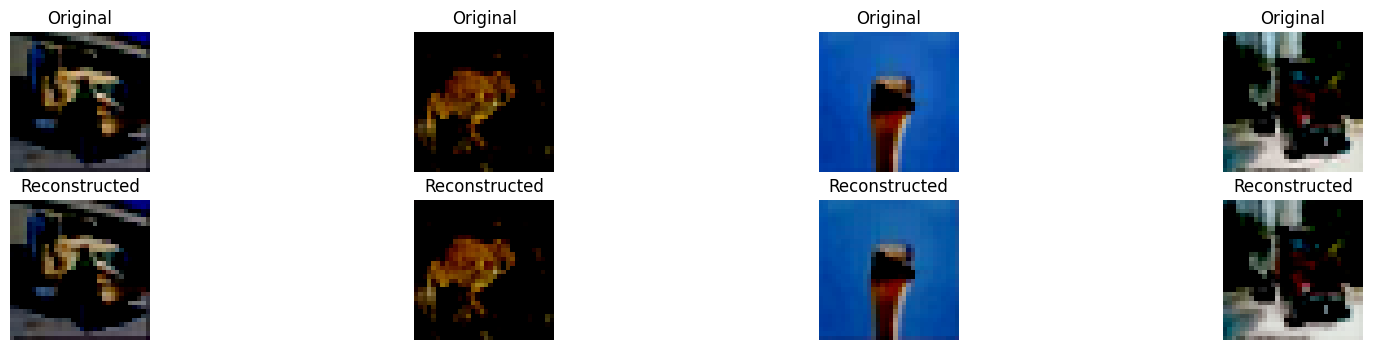

In [13]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, _ in trainloader:
        images = images.to(device)
        outputs = model(images)
        break  # take first batch only

# Show 10 original and reconstructed images
n = 4
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].cpu().permute(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ExtendConvAE(nn.Module):
    def __init__(self):
        super(ExtendConvAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),   # 32x32x3 -> 32x32x8
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 32x32x8 -> 16x16x8

            nn.Conv2d(8, 12, kernel_size=3, padding=1), # 16x16x8 -> 16x16x12
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 16x16x12 -> 8x8x12

            nn.Conv2d(12, 16, kernel_size=3, padding=1),# 8x8x12 -> 8x8x16
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'), # 8x8x16 -> 16x16x16
            nn.Conv2d(16, 12, kernel_size=3, padding=1), # 16x16x16 -> 16x16x12
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'), # 16x16x12 -> 32x32x12
            nn.Conv2d(12, 3, kernel_size=3, padding=1),  # 32x32x12 -> 32x32x3
            nn.Tanh()  # if normalized to [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [15]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ExtendConvAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, images).item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/5], Train Loss: 0.0480, Val Loss: 0.0302
Epoch [2/5], Train Loss: 0.0280, Val Loss: 0.0250
Epoch [3/5], Train Loss: 0.0243, Val Loss: 0.0232
Epoch [4/5], Train Loss: 0.0227, Val Loss: 0.0219
Epoch [5/5], Train Loss: 0.0216, Val Loss: 0.0207


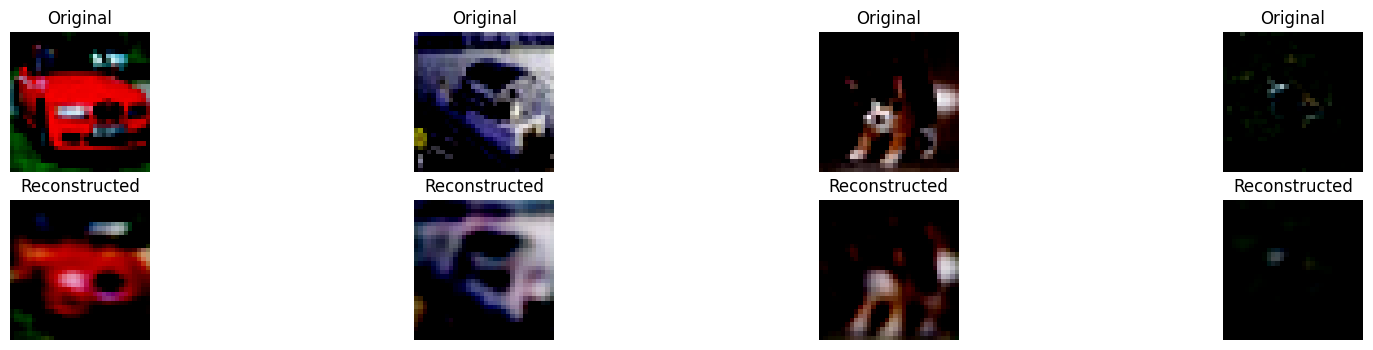

In [21]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, _ in trainloader:
        images = images.to(device)
        outputs = model(images)
        break  # take first batch only

# Show 10 original and reconstructed images
n = 4
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].cpu().permute(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()


# Why Reconstructions Look Worse with CNN + Pooling AE

- **Pooling causes information loss** → downsampling (32×32 → 16×16 → 8×8) removes pixel detail.  
- **Bottleneck too restrictive** → latent space (8×8×16 = 1024) is smaller than simple AE, limiting capacity.  
- **Decoder too shallow** → fewer layers, struggles to reconstruct fine textures.  
- **MSE loss prefers blurriness** → minimizes average error, loses sharp edges.  
- **Training issues** → CNN needs more epochs / tuned learning rate.

**Summary:**  
Simple AEs often give sharper reconstructions since they keep pixel info, while CNN + pooling AEs trade off detail for more abstract feature learning.  
